# The anharmonic oscillator
Contributions:
- All
    - Identifying the calculations to be run
    - Code reviews
- Gabe DeLong
    - Derivation of the Verlet integrator
    - Suggesting that a Euler step should be used for the first step
- Enez Suyabatmaz
    - Writing up of the physical intepretations of the numerical results
    - Writing the skeleton code
- Brian Zhao
    - Code clean-up, making the AnharmParticle class
    - Make plots

## The Verlet integrator
$$
r(t+\delta t) = 2r(t)-r(t-\delta t)+\frac{f(t)}{m}\delta t^2+\mathcal{O}(\delta t^4)
$$
$$
v(t)=\frac{r(t+\delta t)-r(t-\delta t)}{2\delta t}+\mathcal{O}(\delta t^2)
$$

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class AnharmParticle:
    def __init__(self, dt, time, x0, v0=None, temp=None):
        # Initial conditions
        self.x0 = x0
        self.v0 = v0
        self.T = temp
        if (v0 is None and temp is None):
            raise RuntimeError('Either v0 or temp needs to be provided! (The latter overrides if both are provided)')
        self.a0 = None
        self.iter = 0 # So that the storage index is intuitive
        
        # integrator
        self.dt = dt
        self.maxiter = int(time/dt)
        
        # Properties
        self.x = None
        self.v = None
        self.a = None
        self.ke = None
        self.pe = None
        self.etot = None
        
        # Scratch variable for Verlet
        self.x_old = None
        
        # Data storage
        self.t_points = np.arange(0, self.maxiter) * dt
        self.x_traj = np.zeros(self.maxiter)
        self.v_traj = np.zeros(self.maxiter)
        
        self.initialise()
        
    def initialise(self):
        if (self.iter != 0):
            raise RuntimeError("AnharmParticle.initialise() called after initialisation")
        else:
            if (self.T is None):
                self.energyEval()
                self.etot = self.ke + self.pe
                self.T = 2*self.etot
            else:
                # We have to find the initial velocity consistent with the temperature and initial position
                self.etot = self.T/2
                self.pe = self.potEval(self.x0)
                self.ke = self.etot - self.pe
                if (self.ke < 0):
                    raise RuntimeError('The temperature constraint cannot be satisfied!')
                self.v0 = np.sqrt(self.ke*2) # We just take the positive root, since there's time-reversal symmetry
            self.x = self.x0
            self.v = self.v0
            self.forceEval()
            self.a0 = self.a # So that the complete set of initial conditions is available
            self.x_traj[self.iter] = self.x
            self.v_traj[self.iter] = self.v
            self.iter += 1
    
    def energyEval(self):
        self.ke = 0.5 * self.v**2
        self.pe = 0.5 - self.x**2 + 0.5*self.x**4
        
    @staticmethod
    def potEval(x):
        return (0.5 - x**2 + 0.5*x**4)
        
    def forceEval(self):
        # Restoring force points in the opposite direction: F = -dV/dx
        self.a = 2*self.x - 2*self.x**3
    
    def run_MD(self):
        while self.iter < self.maxiter:
            self.verletStep()
            self.x_traj[self.iter] = self.x
            self.v_traj[self.iter] = self.v
            self.iter += 1
    
    def reset(self):
        self.iter = 0
        self.initialise()
        
    def eulerStep(self):
        self.x = self.x + self.v * self.dt
        self.v = self.v + self.a * self.dt
        self.forceEval()
        
    def verletStep(self):
        if self.iter == 1:
            # first Verlet iteration has to be Euler, since we don't have the -1-th iteration data
            self.x_old = self.x + self.v * self.dt
            self.forceEval()
        
        x_new = 2*self.x - self.x_old + self.a*(self.dt**2)
        self.v = (x_new - self.x_old)/(2*self.dt)
        self.x_old = self.x
        self.x = x_new
        self.forceEval()
        
    def plotTraj(self, sum_energy=False):
        f,ax = plt.subplot_mosaic(
        '''
        AAAAACC
        BBBBBCC
        ''',figsize=(15,5))
        ax['A'].plot(self.t_points[1:], self.x_traj[1:], label=r'x(t)')
        ax['A'].plot(self.t_points[1:], self.v_traj[1:], label=r'v(t)')
        ax['A'].legend()

        ax['B'].plot(self.t_points, 0.5*(self.v_traj)**2, label=r'$\mathrm{{KE}}(t)$', color='tab:green')
        ax['B'].plot(self.t_points, self.potEval(self.x_traj), label=r'$\mathrm{{PE}}(t)$', color='tab:red')
        if (sum_energy):
            etot = self.potEval(self.x_traj)+0.5*(self.v_traj)**2
            ax['B'].plot(self.t_points, etot, label=r'$E_{{\mathrm{{tot.}}}}(t)$', color='tab:purple')
            #axins = ax['B'].inset_axes([0.5,0.5,0.2,0.2])
            #axins.plot(self.t_points, self.potEval(self.x_traj)+0.5*(self.v_traj)**2, label=r'$E_{{\mathrm{{tot.}}}}(t)$', color='tab:purple')
            #axins.axhline(self.etot, c='k', linestyle='--', linewidth=1, label=r'$E_{{\mathrm{{tot.}}}}$')
            #axins.set_ylim([max(etot),min(etot)])
        ax['B'].axhline(self.etot, c='k', linestyle='--', linewidth=1, label=r'$E_{{\mathrm{{tot.}}}}$')
        ax['B'].axhline(0, c='k',linewidth=1)
        ax['B'].set_xlabel(r'$t$')
        ax['B'].legend()

        ax['C'].scatter(self.x_traj,self.v_traj,marker='.',c='slategray',label='Phase space trajectory')
        ax['C'].scatter(self.x0,self.v0,marker='x',c='purple',label='Initial conditions')
        ax['C'].legend()
        ax['C'].set_xlabel(r'$x$')
        ax['C'].set_ylabel(r'$v$')
        ax['C'].yaxis.tick_right()
        ax['C'].yaxis.set_label_position('right')

        _=f.suptitle(r'Trajectories for $T={t:.3f}$, $x_0={x0:.3f}$, $v_0={v0:.3f}$, $E_{{\mathrm{{tot.}}}}={etot:.3f}$, $\delta t={dt:.5f}$'
                     .format(t=self.T, x0=self.x0, v0=self.v0, etot=self.etot, dt=self.dt))
    
    def getx2avg(self):
        return sum((self.x_traj[1:]**2))/(p1.maxiter-1)

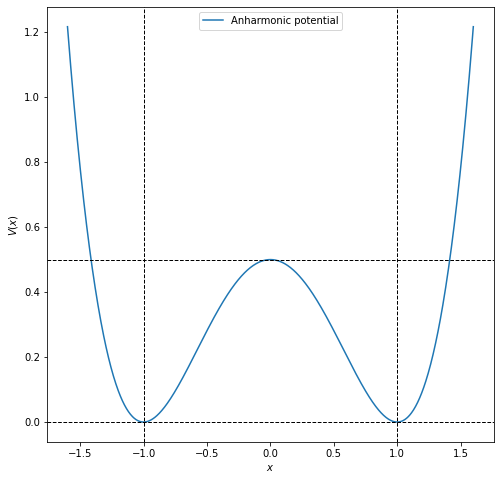

In [2]:
x = np.linspace(-1.6,1.6,1000)
v = AnharmParticle.potEval(x)
f,ax = plt.subplots(figsize=(8,8))
ax.plot(x,v,label='Anharmonic potential')
ax.axhline(0,c='k',linestyle='--',linewidth=1)
ax.axhline(0.5,c='k',linestyle='--',linewidth=1)
ax.axvline(-1,c='k',linestyle='--',linewidth=1)
ax.axvline(+1,c='k',linestyle='--',linewidth=1)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$V(x)$')
ax.legend()

Initializing the system in the bottom of one of the wells, we expect the behavior to be almost harmonic if $T\ll 1$, as shown below, where the phase space trajectory being almost perfectly elliptical, meaning $ax^2+bv^2=\mathrm{const.}$, which is expected from a harmonic oscillator with $E=0.5(v^2+kx^2)=\mathrm{const.}$

We first attempt to find a stable time-step to use for the Verlet integrator. To do this, we plot the convergence behaviour of $\langle x^2\rangle$ averaged over a fixed time period (this might not give the microcanonical average but should still converge as we're using the same time period) as $\delta t$ is varied.

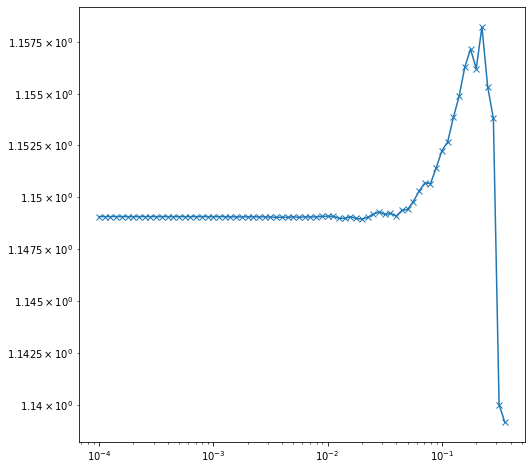

In [242]:
dts = np.arange(-4,-0.4,0.05)
dts = 10**dts
x2 = np.zeros(len(dts))
for i, dt in enumerate(dts):
    p1 = AnharmParticle(dt, 25, x0=-1, v0=None, temp=3)
    p1.run_MD()
    x2[i] = p1.getx2avg()

f,ax = plt.subplots(figsize=(8,8))
ax.loglog(dts, x2, marker='x')

We show visually how this looks with increasingly large time-steps. Starting with what looks like the maximal time step, $\delta t=0.005$.

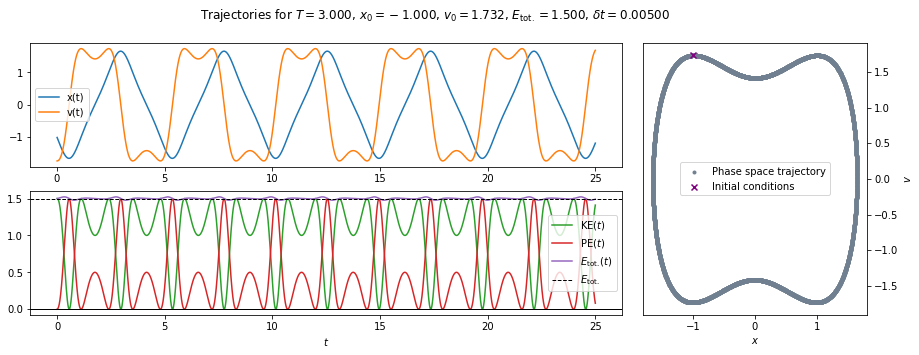

In [36]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=3)
p1.run_MD()
p1.plotTraj(sum_energy=True)

We plot the variation of the actual total energy, which at $\delta t=0.005$ is visibly varying, albeit slightly. As we increase $\delta t=0.01$, this becomes slightly more severe.

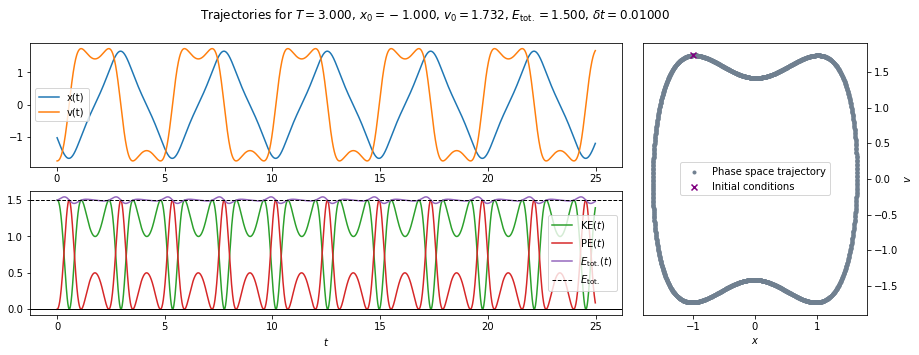

In [38]:
p1 = AnharmParticle(0.01, 25, x0=-1, v0=None, temp=3)
p1.run_MD()
p1.plotTraj(sum_energy=True)

Upon increasing $\delta t$ further to 0.05, we can see a skew/asymmetry in the phase space trajectory, on top of dramatic oscillations in total energy, showing that energy is clearly no longer conserved (as the trajectory should be symmetrical about the $x$ and $v$ axes).

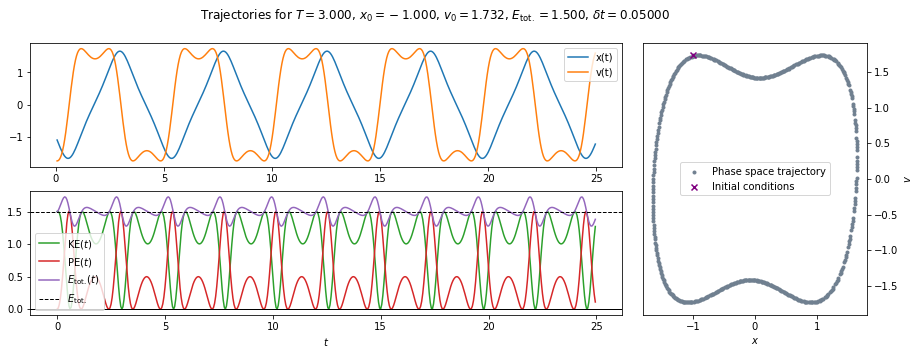

In [15]:
p1 = AnharmParticle(0.05, 25, x0=-1, v0=None, temp=3)
p1.run_MD()
p1.plotTraj(sum_energy=True)

The effect only gets worse upon further increase in the time step. This time, the energy non-conservation can be directly observed in the bottom plot of the energy contributions, where the potential energy periodically overshoots the theoretical total energy.

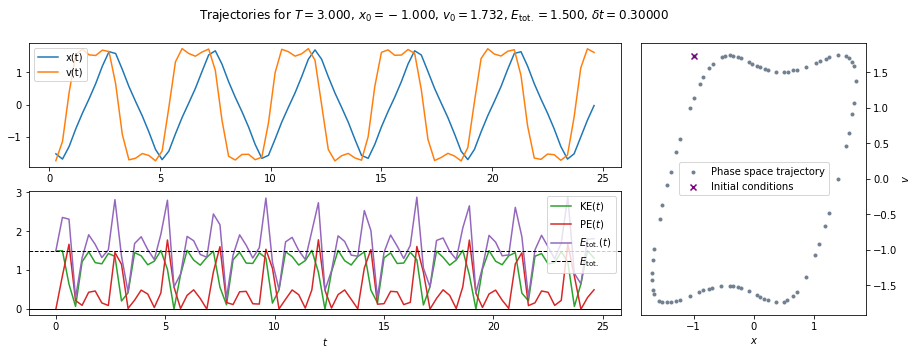

In [17]:
p1 = AnharmParticle(0.3, 25, x0=-1, v0=None, temp=3)
p1.run_MD()
p1.plotTraj(sum_energy=True)

We can conclude that a maximum time-step of 0.005 can be used.

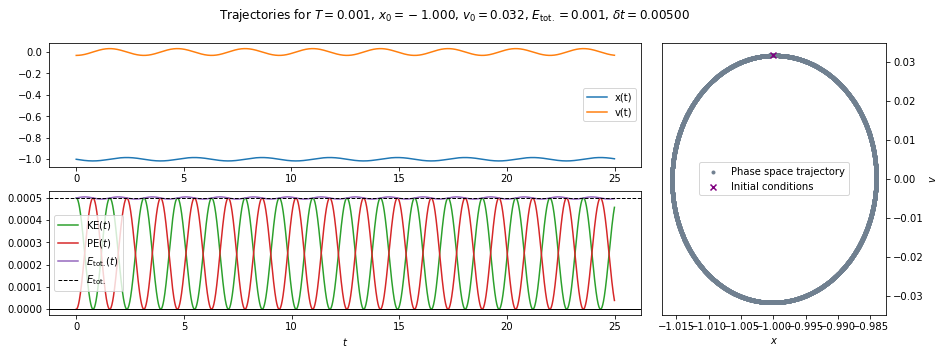

In [40]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=0.001)
p1.run_MD()
p1.plotTraj(sum_energy=True)

With increasing temperature, the deviation from a elliptical phase space trajectory increases, as the particle explores the more anharmonic parts of the well.

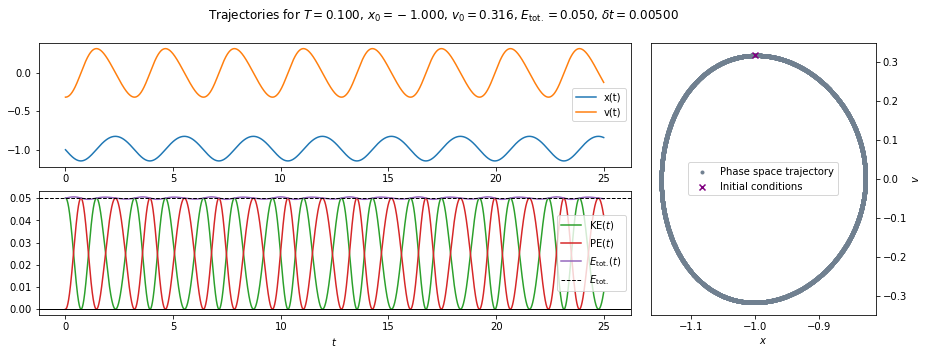

In [41]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=0.1)
p1.run_MD()
p1.plotTraj(sum_energy=True)

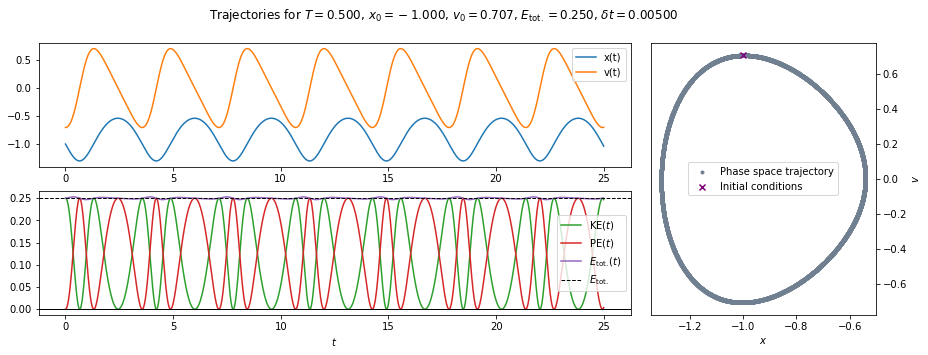

In [42]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=0.5)
p1.run_MD()
p1.plotTraj(sum_energy=True)

The most dramatic of such deviation occurs at $T\rightarrow 1$, where the particle has almost enough energy to overcome the barrier between the two wells, but not quite. So the particle spends a long time being almost stationary near the middle turning point, has it provides almost no restoring force.

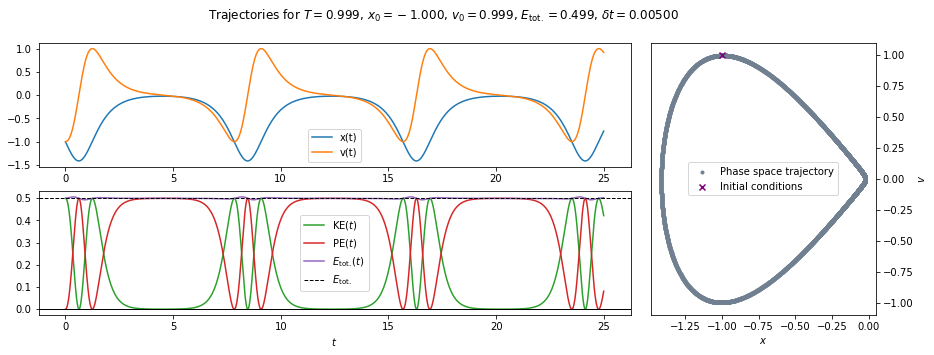

In [45]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=0.999)
p1.run_MD()
p1.plotTraj(sum_energy=True)

At $T=1$, the particle should come to a complete stop on top of the quadratic maximum, but due to the finite time step used, this is not possible to be computationally realized. However, using a smaller time step enables it to rest for longer. This should theoretically give a infinite-time $\langle x^2\rangle$ of exactly 0, however as we see later this is only approximately achieved.

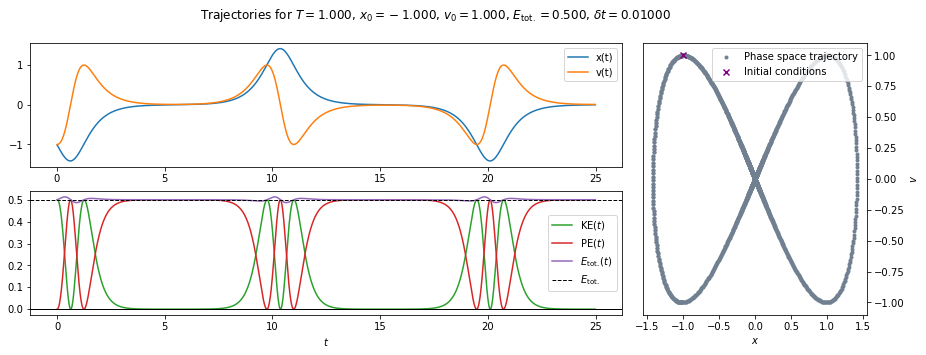

In [51]:
p1 = AnharmParticle(0.01, 25, x0=-1, v0=None, temp=1)
p1.run_MD()
p1.plotTraj(sum_energy=True)

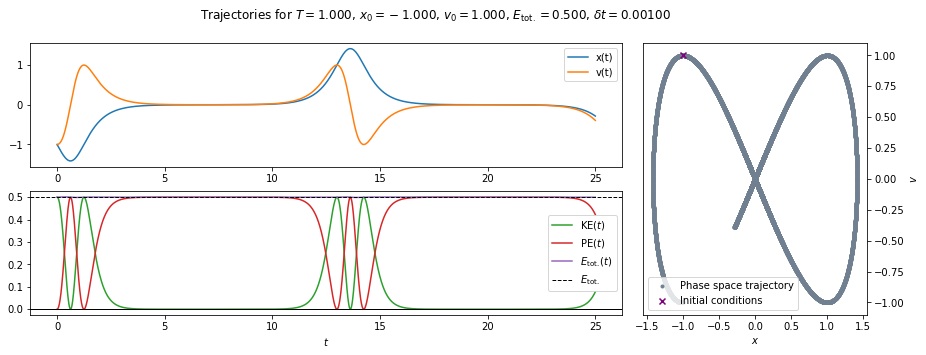

In [50]:
p1 = AnharmParticle(0.001, 25, x0=-1, v0=None, temp=1)
p1.run_MD()
p1.plotTraj(sum_energy=True)

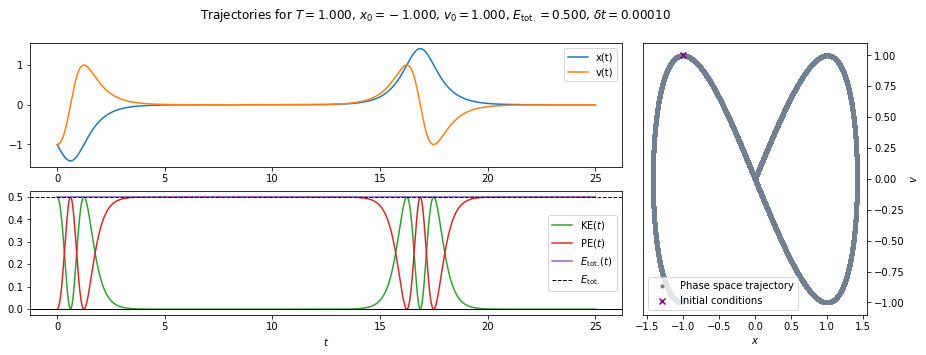

In [47]:
p1 = AnharmParticle(0.0001, 25, x0=-1, v0=None, temp=1)
p1.run_MD()
p1.plotTraj(sum_energy=True)

In this case, the particle rolled back instead of forwards into the other well, further demonstrating the dependence on numerics at this 'critical' temperature.

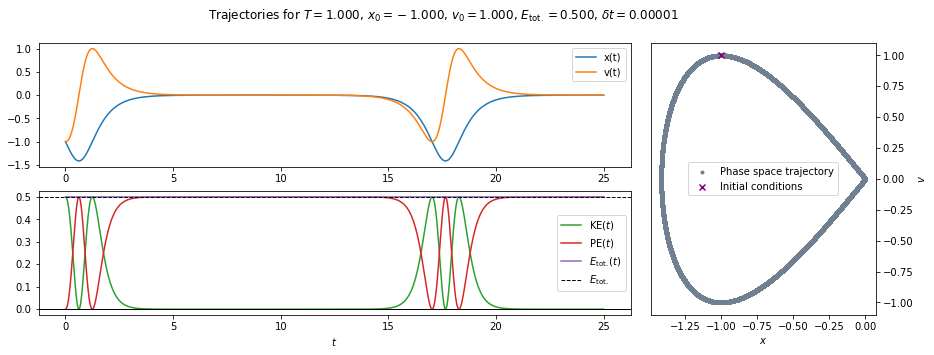

In [52]:
p1 = AnharmParticle(0.00001, 25, x0=-1, v0=None, temp=1)
p1.run_MD()
p1.plotTraj(sum_energy=True)

At $T=1.01$ the energy barrier of $0.5$ can finally be overcome, and from now on, the particle can explore both wells.

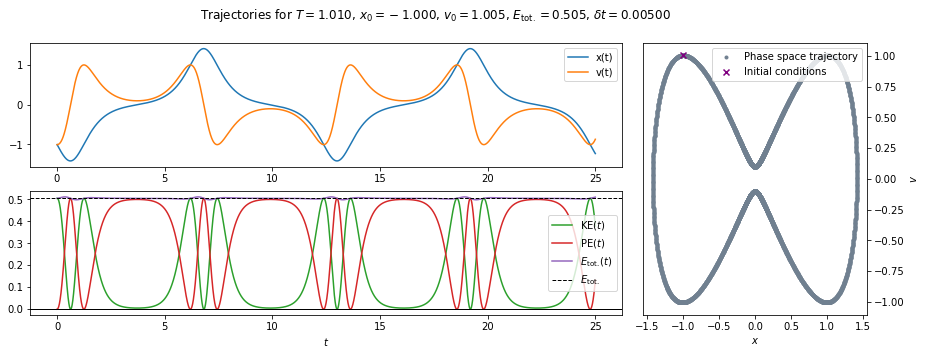

In [49]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=1.01)
p1.run_MD()
p1.plotTraj(sum_energy=True)

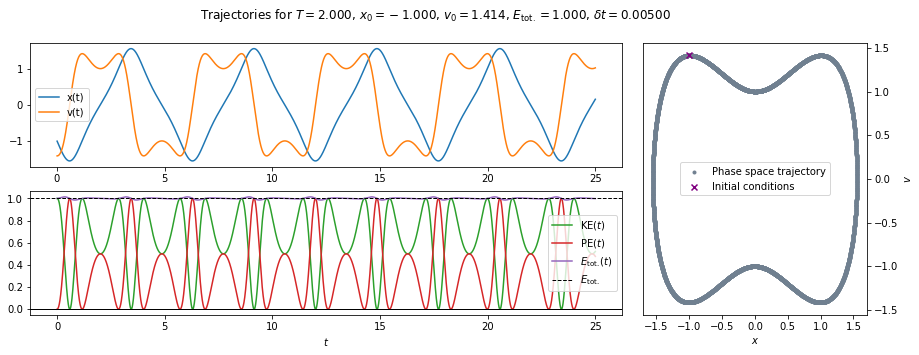

In [53]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=2)
p1.run_MD()
p1.plotTraj(sum_energy=True)

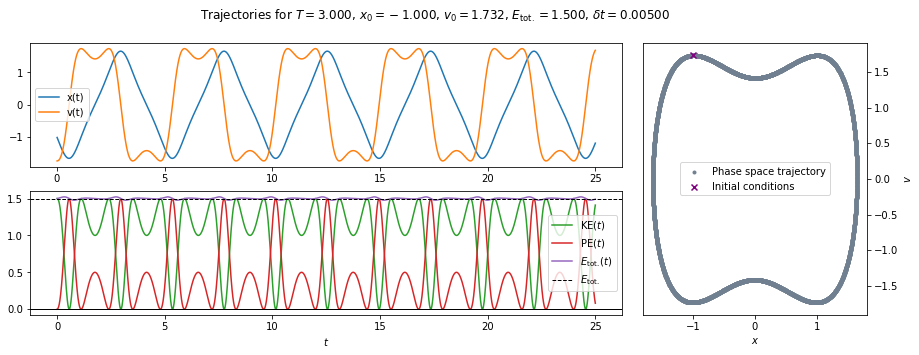

In [54]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=3)
p1.run_MD()
p1.plotTraj(sum_energy=True)

As $T$ increases further, we approach the quartic oscillator limit (giving a more square-ish phase space trajectory, _c.f._ $p$-norm), as the particle spends less and less time in or near the small quadratic bump in the middle of the potential. This is characterized by the gradual disappearance of the dimples in the phase space trajectory.

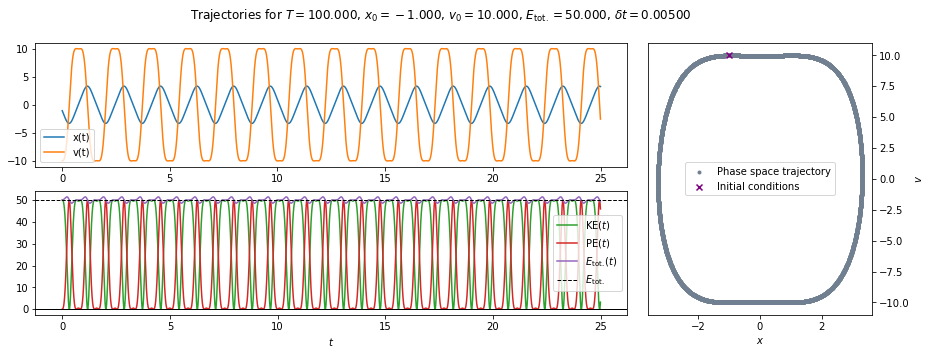

In [55]:
p1 = AnharmParticle(0.005, 25, x0=-1, v0=None, temp=100)
p1.run_MD()
p1.plotTraj(sum_energy=True)

To ensure that the time averages are time-independent, we plot $\langle x^2\rangle(t)$, and observe an oscillatory behaviour modulated by an exponentially decaying envelope. The oscillations are likely due to the fact that the time period integrated over at not fully periodic, and the decaying envelope is due to the former 'boundary effects' mattering less and less. We choose 2000 seconds to integrate over.

Text(0, 0.5, '$\\langle x^2\\rangle$')

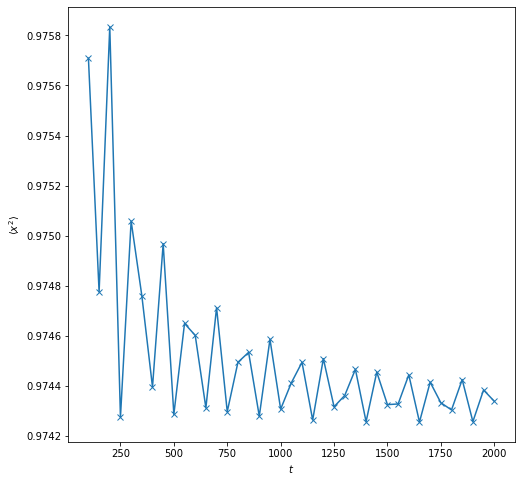

In [56]:
times = np.arange(100,2050,50)
x2 = np.zeros(len(times))
for i, time in enumerate(times):
    p1 = AnharmParticle(0.005, time, x0=-1, v0=None, temp=0.1)
    p1.run_MD()
    x2[i] = p1.getx2avg()
f,ax = plt.subplots(figsize=(8,8))
ax.plot(times, x2, marker='x')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle x^2\rangle$')

We now calculate the expectation value of $x^2$ as a function of temperature. This summarizes some observations we made before, namely
- At small $T$, the particle spends most of its time near the bottom of the well at $\pm1$ performing nearly harmonic motions.
- At $0<T<1.0$, the particle gains more energy and explores more and more of one of the wells, with the inner wall being gentler (quadratic vs. quartic), it spends more time there, and $\langle x^2\rangle$ decreases as a result.
- At $T=1.0$, the particle barely makes over the potential barrier (or rolls back, both of which is a computational artefact due to non-vanishing restoring force at the maximum, due to the particle not being exactly at the maximum from space-discretization, or floating point residues), and dwells at the top of the barrier (at $x=0$) for a long time (which physically it should come to a complete rest, giving an infinite-time $\langle x^2\rangle=0$, but this is computationally unfeasible as it requires infinitely small time-steps and infinitely long simulation time), hence obtaining the lowest $\langle x^2\rangle$.
- At $T>1.0$, the particle effectively explores a quartic potential with an increasingly small quadratic perturbation at the origin, and with higher temperature it spends more and more time at larger $|x|$, hence $\langle x^2\rangle$ increases monotonously with temperature.

Text(0, 0.5, '$\\langle x^2\\rangle$')

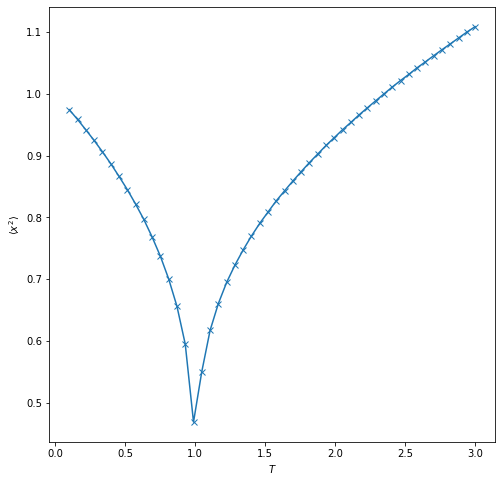

In [57]:
temps = np.linspace(0.1,3,50)
x2 = np.zeros(len(temps))
for i, temp in enumerate(temps):
    p1 = AnharmParticle(0.005, 2000, x0=-1, v0=None, temp=temp)
    p1.run_MD()
    x2[i] = p1.getx2avg()
f,ax = plt.subplots(figsize=(8,8))
ax.plot(temps, x2, marker='x')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\langle x^2\rangle$')